# ЗАДАНИЕ ПО ВЫЧМАТАМ
# ВАРИАНТ 7.5. Численное решение жесткой системы

In [253]:
import numpy as np
from math import sqrt
import scipy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
from sympy.interactive import printing
printing.init_printing(use_latex=True)
from package_tqdm import *  # может быть конфликт имен до РК

# Суточные колебания концентрации озона в атмосфере
# Рассмотрим простейшую математическую модель колебаний концентрации озона в атмосфере
# Она описывается следующей неавтономной системой ОДУ

In [129]:
y1 = sp.Symbol('y1')
y2 = sp.Symbol('y2')
y3 = sp.Symbol('y3')
t = sp.Symbol('t')
k1 = sp.Symbol('k1')
k2 = sp.Symbol('k2')
k3 = sp.Symbol('k3')
k4 = sp.Symbol('k4')
omega = sp.Symbol('ω')
c3 = sp.Symbol('c3')
c4 = sp.Symbol('c4')
y1_0 = sp.Symbol('y1_0')
y2_0 = sp.Symbol('y2_0')
y3_0 = sp.Symbol('y3_0')  # определяем переменные LaTex
dydt_1 = sp.Function('y1')(y1,y2,y3,t)
dydt_2 = sp.Function('y2')(t)
dydt_3 = sp.Function('y3')(y1,y2,y3,t)  # определяем функции LaTex (уравнения системы)
dydt_1 = dydt_1.diff(t)
dydt_2 = dydt_2.diff(t)
dydt_3 = dydt_3.diff(t)  # вид dy/dt

In [130]:
def kineq(y1, y2, y3, k1, k2, k3, k4):  # функция доступа к уравнениям системы kinetic equation
    dydt_1 = -k1*y1*y2 - k2*y1*y3 + 2*k3*y2 + k4*y3
    dydt_2 = 0  # O2 вообще не считаем
    dydt_3 = k1*y1*y2 - k2*y1*y3 - k4*y3
    return {1:dydt_1, 2: dydt_2, 3:dydt_3}

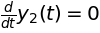

In [7]:
display(sp.Eq(dydt_1, kineq(y1, y2, y3, k1, k2, k3, k4)[1]))
display(sp.Eq(dydt_2, kineq(y1, y2, y3, k1, k2, k3, k4)[2]))
display(sp.Eq(dydt_3, kineq(y1, y2, y3, k1, k2, k3, k4)[3]))

# Определим параметры системы, начальные условия
# Параметры k3, k4 пока покажем оценочно, для представления картины

In [131]:
sp.Eq(omega,np.pi/43200), \
sp.Eq(k1,1.63e-16), \
sp.Eq(k2,4.66e-16), \
sp.Eq(k3, 0), \
sp.Eq(c3,22.62), \
sp.Eq(c4,7.601), \
sp.Eq(y1_0,1e6), \
sp.Eq(y2_0,3.7e16), \
sp.Eq(y1_0,1e12)  # вид, показано до определения

# Система умеренно жесткая днем

In [148]:
'k3 = 0, так и не хватило света',\
'k4 = array([5.03000000e+00, 5.06000000e+00, 5.09000000e+00, ..., \
        1.11149793e+06, 1.11316242e+06, 1.11482895e+06])'

('k3 = 0, так и не хватило света',
 'k4 = array([5.03000000e+00, 5.06000000e+00, 5.09000000e+00, ...,         1.11149793e+06, 1.11316242e+06, 1.11482895e+06])')

In [132]:
omega = np.pi/43200  # частота колебаний, c-1
k1, k2 = 1.63e-16, 4.66e-16  # константы скорости
c3, c4 = 22.62, 7.601  # константы дневных колебаний функции exp(-c/sin(wt)), функция определяет зависимость \ 
# k3 и k4 от времени

In [133]:
t = np.arange(0, 8084, 1)  # точки времени, возьмем небольшое время с шагом в 100 с
def light_dep(w, c, m):  # функция определения k3 и k4, зависимость от дневных колебаний, возвращает массив
    res = np.arange(0)
    for _ in t:
        if np.sin(w*_) <= 0.0:  # 
            continue
        elif round(np.exp(-c/np.sin(w*_))*m):  # округляем тысячные доли до нуля в сравнении с остальными членами y 
            res = np.append(res, round(np.exp(-c/np.sin(w*_))*10*m, 2))  
    if not res.size>0:
        res = 0  # если так и не было света (или слишком мало, округлили)
    return res

In [134]:
k3, k4 = light_dep(omega, c3, 1e15), light_dep(omega, c4, 1e11)  # округлили до -17 и -13 соответсвенно

In [135]:
y1_0, y2_0, y3_0 = 1e6, 3.7e16, 1e12  # начальные концентрации, см-3 

# Реализуем схему Розенброка CROS
# 1. Получим численное решение, шаг возьмем из других методов
# 2. Построим график решения
# 3. Построим функцию устойчивости

# Описание CROS

In [207]:
y_n = sp.Symbol('Yn')
h = sp.Symbol('h')
t = sp.Symbol('t')
re_w = sp.Symbol('Rew')
e = sp.Symbol('E')
j = sp.Symbol('J') 
gamma = sp.Symbol('γ')
w = sp.Symbol('w')
t0 = sp.Symbol('t0')
y0 = sp.Symbol('y0')
alpha = sp.Symbol('α')
y_n1 = sp.Function('Yn+1')(t)
x = sp.Function('')(t0+alpha*h)
f = sp.Function('f')(x, y0)

In [208]:
display(sp.Eq((e - gamma*h*j)*w, f))  # одностадийная схема Розенброка первого порядка аппроксимации, \
# L1 устойчивость, b = 1
display(sp.Eq(y_n1, y_n + h*re_w))  # итерационное решение 

In [210]:
gamma = 0.5 + 0.5j  # выберем гамма для L2, Reγ = 1/2
display(sp.Eq((e - gamma*h*j)*w, f.subs(alpha,0.5)))  # одностадийная схема Розенброка второго \
# порядка аппроксимации, L2 устойчивость, α = Reγ = 1/2
display(sp.Eq(y_n1, y_n + h*re_w))  # итерационное решение 

# Функция устойчивости CROS (h^2)

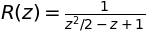

In [212]:
z = sp.Symbol('z')
r_z = sp.Function('R')(z)
display(sp.Eq(r_z, 1/(1 - z + (z**2)/2)))

# Построим матрицу Якоби системы ОДУ для начальных условий

In [263]:
vars = sp.symbols('y1 y2 y3') # определение переменных
f = sp.sympify(['-k1*y1*y2 - k2*y1*y3 + 2*k3*y2 + k4*y3', '0', 'k1*y1*y2 - k2*y1*y3 - k4*y3']) # определение функции
jacoby = sp.zeros(len(f),len(vars)) # создание матрицы нулей с зависимостью f(y)

In [264]:
# заполнение матрицы, теперь это м Якоби 
for i, fi in enumerate(f):
     for j, s in enumerate(vars):
            jacoby[i,j] = sp.diff(fi, s)
display(jacoby)  # вид

⎡-k₁⋅y₂ - k₂⋅y₃  -k₁⋅y₁ + 2⋅k₃  -k₂⋅y₁ + k₄⎤
⎢                                          ⎥
⎢      0               0             0     ⎥
⎢                                          ⎥
⎣k₁⋅y₂ - k₂⋅y₃       k₁⋅y₁      -k₂⋅y₁ - k₄⎦

In [265]:
def float_jacoby_filler(y1_0, y2_0, y3_0, k1, k2, k3, k4):  #  к сожалению, заполнить матрицу числами оказалось не так просто
    values = []
    values.append(-k1*y2_0 - k2*y3_0)  #11
    values.append(-k1*y1_0 + 2*k3)  #12
    values.append(-k2*y1_0 + k4)  #13
    values.append(0)  #21
    values.append(0)  #22
    values.append(0)  #23
    values.append(k1*y2_0 - k2*y3_0)  #31
    values.append(k1*y1_0)  #32
    values.append(-k2*y1_0 - k4)  #33
    return values  # заполняем вручную

In [266]:
j = sp.Matrix(3, 3, float_jacoby_filler(y1_0, y2_0, y3_0, k1, k2, k3, k4))  \
# Якоби в y0 с числами, финальный показательный вариант, там лежат k4(t), надо будет перевычислять j \
# каждый раз, как и kineq[n]
display(j)  # вид

⎡-6.031466  -1.62998e-10  -4.65e-10⎤
⎢                                  ⎥
⎢    0           0            0    ⎥
⎢                                  ⎥
⎣6.030534     1.63e-10    -4.67e-10⎦

# Составим уравнение схемы

In [142]:
gamma = (1+1j)/2
t0 = 0
h = 10  # шаг
t_end = 172800
e = sp.eye(3)  # E matrix
k3, k4 = 1e-15, 1e-12
j = sp.Matrix(3, 3, float_jacoby_filler(y1_0, y2_0, y3_0, k1, k2, k3, k4)) \
# 2 строки выше - антикраш ImmutableDenseDim (не работает с array), а так там массив
matr = e - gamma*h*j  # a(t) для уравнения a(t)w = f(y0(k(t)))

In [143]:
display(matr) # вид

⎡31.15733 + 30.15733⋅ⅈ   8.1499e-10 + 8.1499e-10⋅ⅈ     2.325e-9 + 2.325e-9⋅ⅈ  
⎢                                                                             
⎢          0                         1                           0            
⎢                                                                             
⎣-30.15267 - 30.15267⋅ⅈ   -8.15e-10 - 8.15e-10⋅ⅈ    1.000000002335 + 2.335e-9⋅

 ⎤
 ⎥
 ⎥
 ⎥
ⅈ⎦

# Реализация

In [144]:
t = np.linspace(t0, t_end+1, t_end//h)  # задаем значения Ох, шаг h
def rosenbrock(func):  # чудеса реализации; сделаем функцию декоратор для функции задания k3, k4 \
                       #с функцией выбора уравнения выбором поведения функции задания k3, k4
    def especially_for_row_num(row_num):  # with love
        kost = 0  # счетчик для фиксации времени для работы light_dep
        row_num = func(omega, c4, t, row_num)
        assert row_num == 1 or 3
        w = np.arange(0)
        if row_num == 1:
            init_y = y1_0  # выбор y0
        else:
            init_y = y3_0
        y_n = np.array(init_y)  # сюда складываем решение Yn+1 = Yn + hRew, сначала y0
        for _ in np.delete(t, 0):  # нач знач уже лежит на 0 шаге
            k3 = float(func(omega, c3, t[kost]))
            k4 = float(func(omega, c4, t[kost]))
            y = kineq(y1_0, y2_0, y3_0, k1, k2 ,k3, k4)[row_num]
            j = sp.Matrix(3, 3, float_jacoby_filler(y1_0, y2_0, y3_0, k1, k2, k3, k4))
            matr = e - gamma*h*j  # переопредяляем все коэффициенты на каждом шаге \
                                  # _m*w = f(h, y0)
            if row_num!=1:
                _m = matr[6] + matr[7] + matr[8]
                # делаем "деление" на матрицу
            else:
                _m = matr[0] + matr[1] + matr[2]
            # w = np.append(w, (y)/_m); необязательный этап
            y_n = np.append(y_n, init_y + h*sp.re(float(y)/_m))  # Yn+1 = Yn + Rew, _ определят добавление h
            init_y = init_y + h*sp.re(float(y)/_m)
            kost+=1
        return y_n  # массив решений
    return especially_for_row_num # выполнение функции decorated light_dep

In [229]:
@rosenbrock
def light_dep(w, c, t, row_num=None):  # deprecated function from the very beginning - переделал
    if not row_num:
        res = np.arange(0)
        if np.sin(w*t) <= 0.0:
            res = 0
        elif round(np.exp(-c/np.sin(w*t)), 18):  
            res = np.append(res, round(np.exp(-c/np.sin(w*t)), 18))  # поставим здесь границу e-18, и так мало влияет
        if res:
            return res
        else:
            return 0
    else:
        return row_num

In [230]:
y_1 = light_dep(1)  # подождем выполнения решения y1 
y_2 = y2_0
y_3 = light_dep(3)  # подождем еще выполнения решения y3

c:\users\константин игоревич\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


In [232]:
display(y_1, y_3)  # вид решений

array([1000000.0, 531.846037277835, -998936.307925444, ...,
       178208607096.393, 178207607628.239, 178206608160.085], dtype=object)

array([1000000000000.0, 999999000568.485, 999998001136.970, ...,
       1175632785611.69, 1175631786180.18, 1175630786748.66], dtype=object)

In [234]:
def oxygen(): 
    return y_1
def ozone():    # так очевиднее
    return y_3

#  Графики

In [293]:
plt.style.use('seaborn-notebook') 

Text(0, 0.5, 'концентрация ат. кислорода y1(t), см-3')

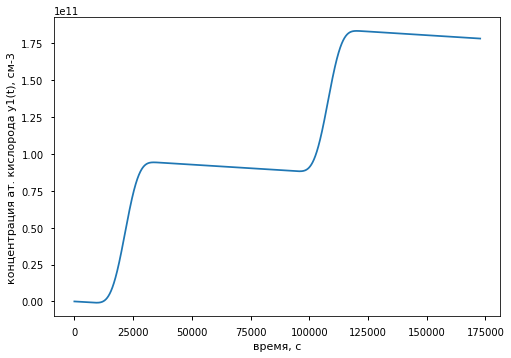

In [296]:
plt.plot(t, oxygen())  # строим кривую решения для кислорода
plt.rcParams(figsize=(16, 24))
plt.xlabel('время, с')
plt.ylabel('концентрация ат. кислорода y1(t), см-3')

Text(0, 0.5, 'концентрация озона y3(t), см-3')

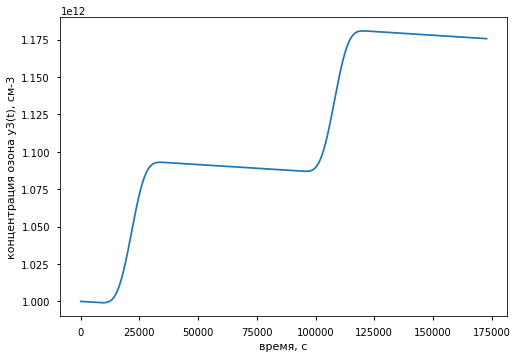

In [333]:
plt.plot(t, ozone())  # строим кривую решения для озона
# plt.scatter(t, ozone(), color='violet') - fun
plt.xlabel('время, с')
plt.ylabel('концентрация озона y3(t), см-3')

Text(0, 0.5, 'концентрация , см-3')

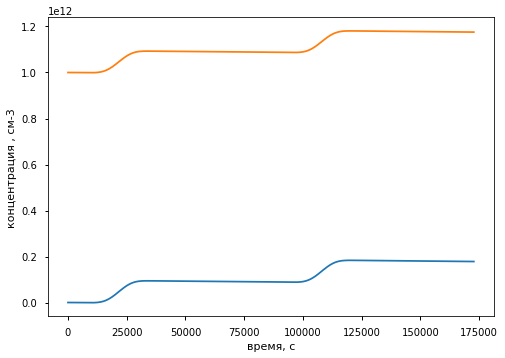

In [332]:
plt.plot(t, oxygen())
plt.plot(t, ozone())
plt.xlabel('время, с')
plt.ylabel('концентрация , см-3')  # на одном графике

# Функция устойчивости

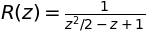

Text(0, 0.5, 'модуль z из C')

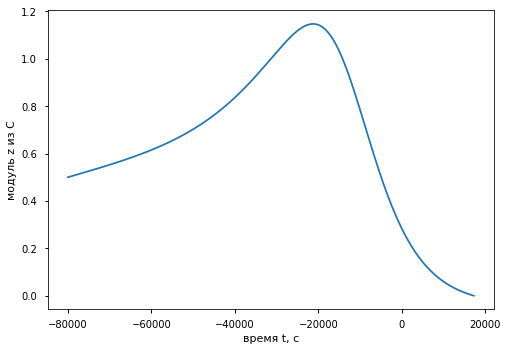

In [318]:
z = sp.Symbol('z')
display(sp.Eq(r_z, 1/(1 - z + (z**2)/2)))
t = np.linspace(-80000, 17280, 1000)
z = np.linspace(0, 1, 1000) + 1j*np.linspace(0, 1, 1000)
x = [x.real for x in z]  # Re
y = [x.imag for x in z]  # Im
plt.plot(t, 1/(1 - z + (z**2))/2)
plt.xlabel('время t, c')
plt.ylabel('модуль z из C')

# |z| < 1 на (-inf, 0] и стремится к нулю

# ............................................

# Реализуем однократно диагональный неявный метод Рунге Кутты с двумя стадиями для случаев
# * 
# **
# ***
# 1. Получим численное решение
# 2. Построим график решения
# 3. Построим функцию устойчивости

## Эталонное решение
В качестве образца использован метод Гаусса, который имеет 6-й порядок аппроксимации. Больше не меньше. Подробнее о методе можно прочитать на странице 47 в книге:
Iserles, Arieh (1996), A First Course in the Numerical Analysis of Differential Equations, Cambridge University Press, ISBN 978-0-521-55655-2
## Да, именно так

In [465]:
def light_dep(w, c, t):  # упрощенная light_dep, просто проверяет условие света 1 раз для данного t
    res = np.arange(0)
    if sp.sin(w*t) <= 0.0:  # 
        res = 0
    elif round(sp.exp(-c/sp.sin(w*t)), 18):  #  поставим здесь границу e-18, и так мало влияет
        res = np.append(res, round(sp.exp(-c/sp.sin(w*t)), 18))  
    if res:
        return res
    else:
        return 0  # если так и не было света (или слишком мало, округлили)

In [485]:
y0 = array([y1_0, y2_0, y3_0])
n_steps = 51  # Количество шагов определяем методом Ньютона; описан в package_tqdm \
# Error: The Newton iteration did not converge.

In [467]:
def dydt(t, y):
    return np.array(list(kineq(y[0], y[1], y[2], k1, k2, light_dep(omega, c3, t), light_dep(omega, c4, t)).values()))

In [468]:
gauss = Gauss(dydt, y0, t0, t_end, n_steps)

In [469]:
gauss.solve()  # офигеть, как долго/ дайте кто нибудь суперкомпьютер





  0%|                                                                                           | 0/52 [00:00<?, ?it/s]c:\users\константин игоревич\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys




  8%|██████▍                                                                            | 4/52 [00:00<00:01, 36.71it/s]



 17%|██████████████▎                                                                    | 9/52 [00:00<00:01, 37.66it/s]



 25%|████████████████████▌                                                             | 13/52 [00:00<00:01, 38.10it/s]



 44%|████████████████████████████████████▎                                             | 23/52 [00:00<00:00, 45.82it/s]



 56%|█████████████████████████████████████████████▋                

# Визуализируем зависимость всех переменных от времени

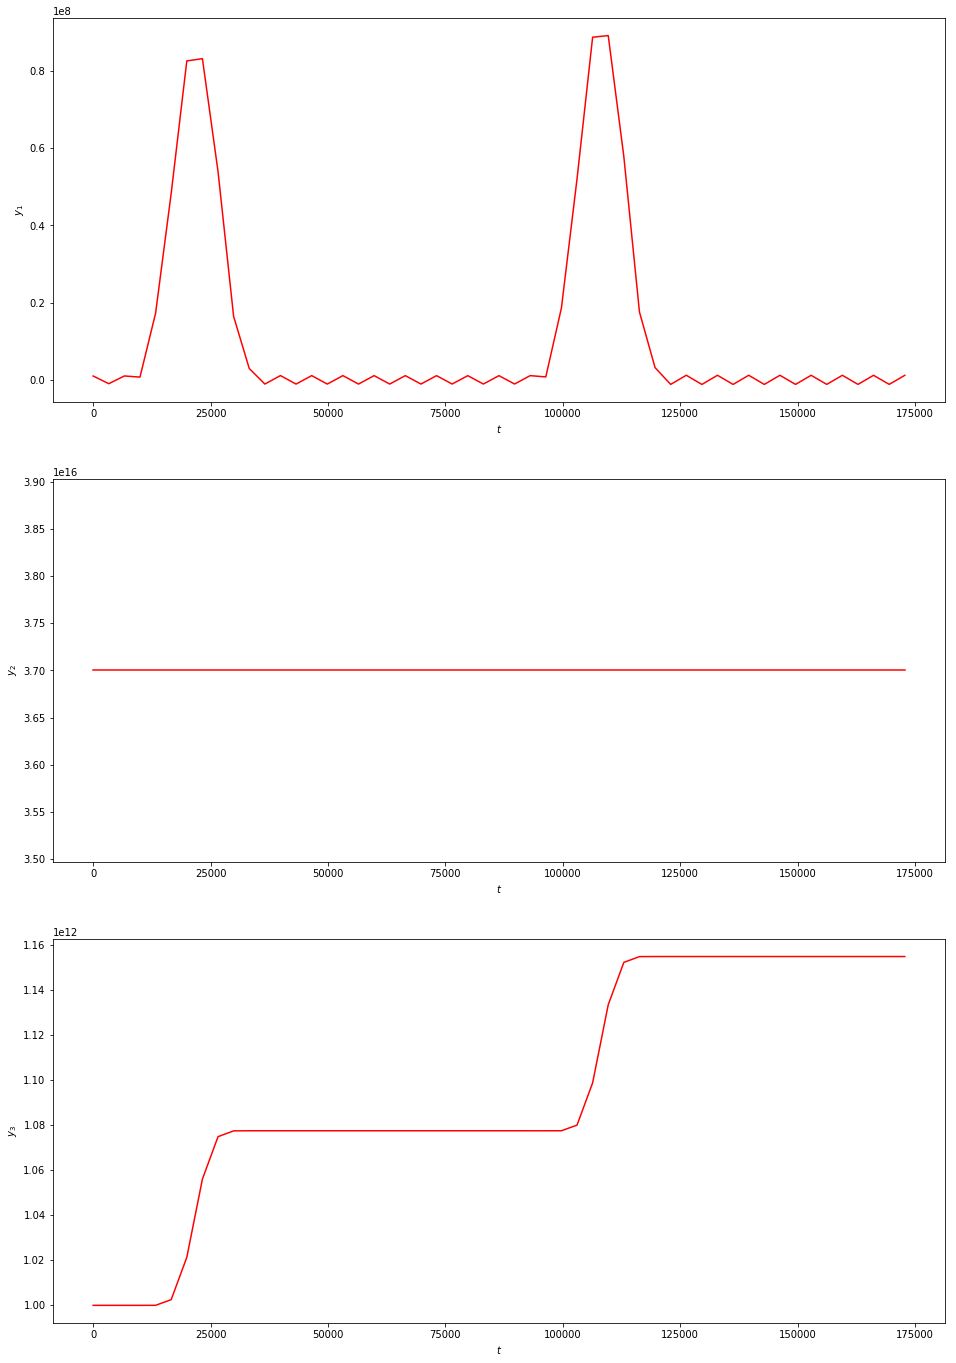




  2%|█▋                                                                        | 2240/100001 [01:40<1:09:55, 23.30it/s]

In [470]:
paragon = np.array(gauss.solution)
fig, axes = plt.subplots(3,1, figsize=(16, 24))
for i, ax in enumerate(axes.flatten()):
    ax.plot(paragon[:, 0], paragon[:, i+1], 'r-')
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$y_{'+str(i+1)+'}$')
plt.show()

# Случай *
# Второго порядка аппроксимации метод с таблицей вида

In [471]:
table_1 = ([(2 + math.sqrt(2))/2, (2 + math.sqrt(2))/2, 0, \
            (2 - math.sqrt(2))/2, (-math.sqrt(2)), (2 + math.sqrt(2))/2, \
            0, 0.5, 0.5])  # список коэфф
butcher_table_1 = sp.Matrix(3,3,table_1)  # табилца бутчера в виде матрицы
display(butcher_table_1)

⎡1.70710678118655   1.70710678118655         0        ⎤
⎢                                                     ⎥
⎢0.292893218813452  -1.4142135623731  1.70710678118655⎥
⎢                                                     ⎥
⎣        0                0.5               0.5       ⎦

In [472]:
matr = butcher_table_1
a = np.array([[matr[1], matr[2]], [matr[4], matr[5]]])  # A матрица в таблице
b = np.array([matr[7], matr[8]])  # b вектор в таблице
c = np.array([matr[0], matr[3]])  # c вектор в таблице
rung_dec = RungeImplicit(a, b, c, dydt, y0, t0, t_end, n_steps)

In [473]:
rung_dec.solve()





  0%|                                                                                           | 0/52 [00:00<?, ?it/s]c:\users\константин игоревич\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys




  4%|███▏                                                                               | 2/52 [00:00<00:02, 19.34it/s]



  8%|██████▍                                                                            | 4/52 [00:00<00:02, 17.95it/s]



 12%|█████████▌                                                                         | 6/52 [00:00<00:02, 16.35it/s]



 15%|████████████▊                                                                      | 8/52 [00:00<00:02, 15.20it/s]



 19%|███████████████▊                                              

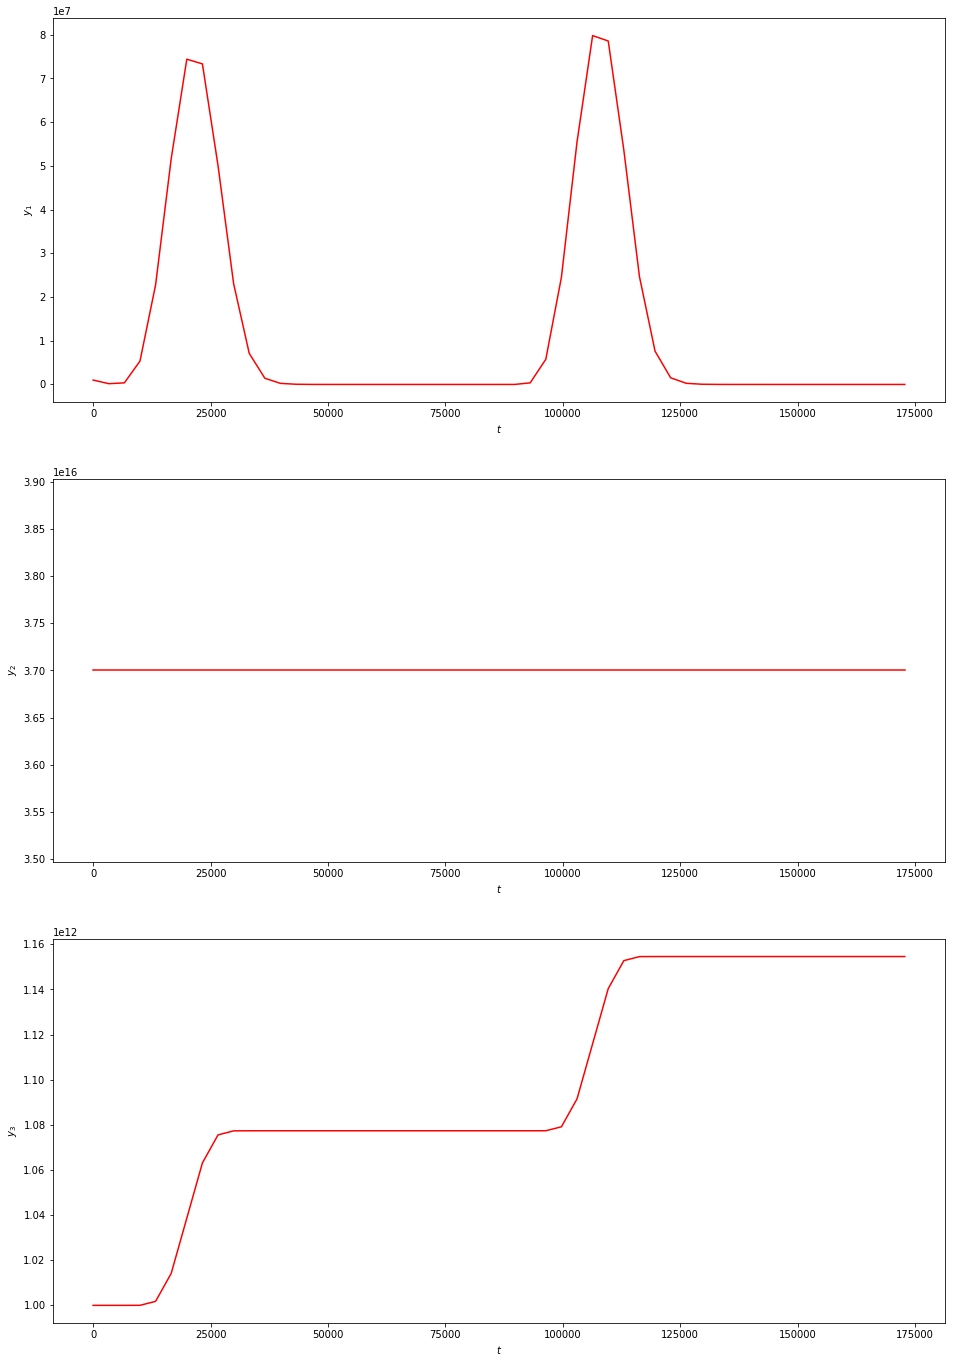

In [475]:
paragon = np.array(rung_dec.solution)
fig, axes = plt.subplots(3,1, figsize=(16, 24))
for i, ax in enumerate(axes.flatten()):
    ax.plot(paragon[:, 0], paragon[:, i+1], 'r-')
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$y_{'+str(i+1)+'}$')
plt.show()

# Случай **
# Асимптотически устойчивый метод с таблицей вида

In [476]:
table_2 = ([(2 - math.sqrt(2))/2, (2 - math.sqrt(2))/2, 0, \
            (2 + math.sqrt(2))/2, (+math.sqrt(2)), (2 - math.sqrt(2))/2, \
            0, 0.5, 0.5])  # список коэфф
butcher_table_2 = sp.Matrix(3,3,table_1)  # табилца бутчера в виде матрицы
display(butcher_table_2)

⎡1.70710678118655   1.70710678118655         0        ⎤
⎢                                                     ⎥
⎢0.292893218813452  -1.4142135623731  1.70710678118655⎥
⎢                                                     ⎥
⎣        0                0.5               0.5       ⎦

In [477]:
matr = butcher_table_2
a = np.array([[matr[1], matr[2]], [matr[4], matr[5]]])  # A матрица в таблице
b = np.array([matr[7], matr[8]])  # b вектор в таблице
c = np.array([matr[0], matr[3]])  # c вектор в таблице
rung_dec = RungeImplicit(a, b, c, dydt, y0, t0, t_end, n_steps)

In [478]:
rung_dec.solve()





  0%|                                                                                           | 0/52 [00:00<?, ?it/s]c:\users\константин игоревич\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys




  6%|████▊                                                                              | 3/52 [00:00<00:02, 19.96it/s]



 10%|███████▉                                                                           | 5/52 [00:00<00:02, 18.29it/s]



 13%|███████████▏                                                                       | 7/52 [00:00<00:02, 16.50it/s]



 17%|██████████████▎                                                                    | 9/52 [00:00<00:02, 15.70it/s]



 21%|█████████████████▎                                            

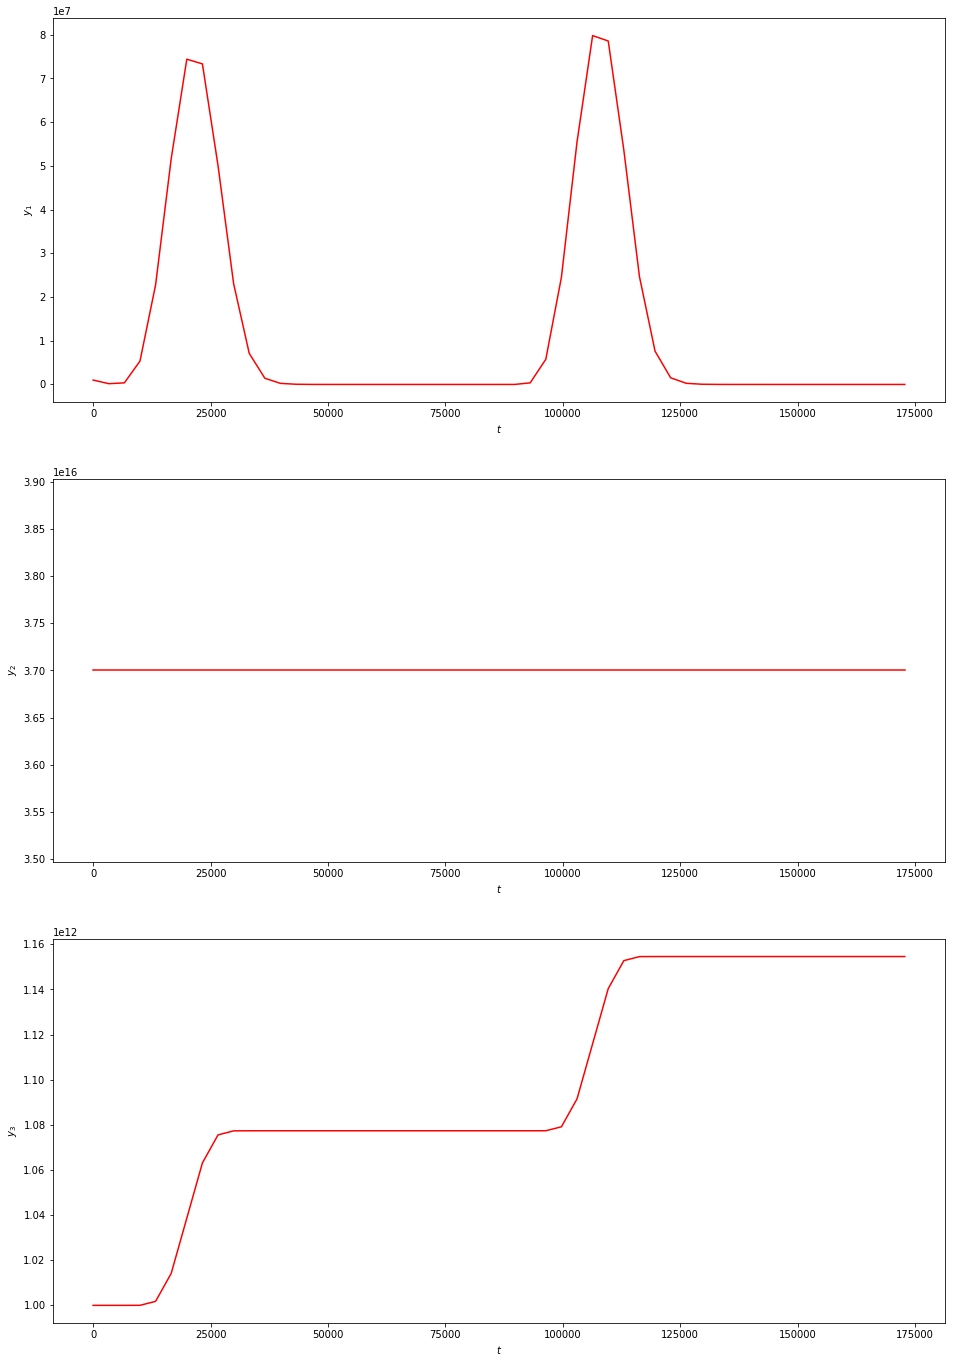

In [479]:
paragon = np.array(rung_dec.solution)
fig, axes = plt.subplots(3,1, figsize=(16, 24))
for i, ax in enumerate(axes.flatten()):
    ax.plot(paragon[:, 0], paragon[:, i+1], 'r-')
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$y_{'+str(i+1)+'}$')
plt.show()

# Случай ***
# Третьего порядка аппроксимации метод с таблицей вида

In [480]:
table_3 = ([(3 + math.sqrt(3))/6, (3 + math.sqrt(3))/6, 0, \
            (3 - math.sqrt(3))/6, (3 - 2*math.sqrt(3))/6, (3 + math.sqrt(3))/6, \
            0, 0.5, 0.5])  # список коэфф
butcher_table_3 = sp.Matrix(3,3,table_1)  # табилца бутчера в виде матрицы
display(butcher_table_3)

⎡1.70710678118655   1.70710678118655         0        ⎤
⎢                                                     ⎥
⎢0.292893218813452  -1.4142135623731  1.70710678118655⎥
⎢                                                     ⎥
⎣        0                0.5               0.5       ⎦

In [487]:
matr = butcher_table_3
a = np.array([[matr[1], matr[2]], [matr[4], matr[5]]])  # A матрица в таблице
a
b = np.array([matr[7], matr[8]])  # b вектор в таблице
c = np.array([matr[0], matr[3]])  # c вектор в таблице
rung_dec = RungeImplicit(a, b, c, dydt, y0, t0, t_end, n_steps)

In [488]:
rung_dec.solve()






  0%|                                                                                           | 0/52 [00:00<?, ?it/s]c:\users\константин игоревич\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys





  4%|███▏                                                                               | 2/52 [00:00<00:02, 18.87it/s]




  8%|██████▍                                                                            | 4/52 [00:00<00:02, 18.19it/s]




 12%|█████████▌                                                                         | 6/52 [00:00<00:02, 16.58it/s]




 15%|████████████▊                                                                      | 8/52 [00:00<00:02, 15.39it/s]




 19%|███████████████▊                                        

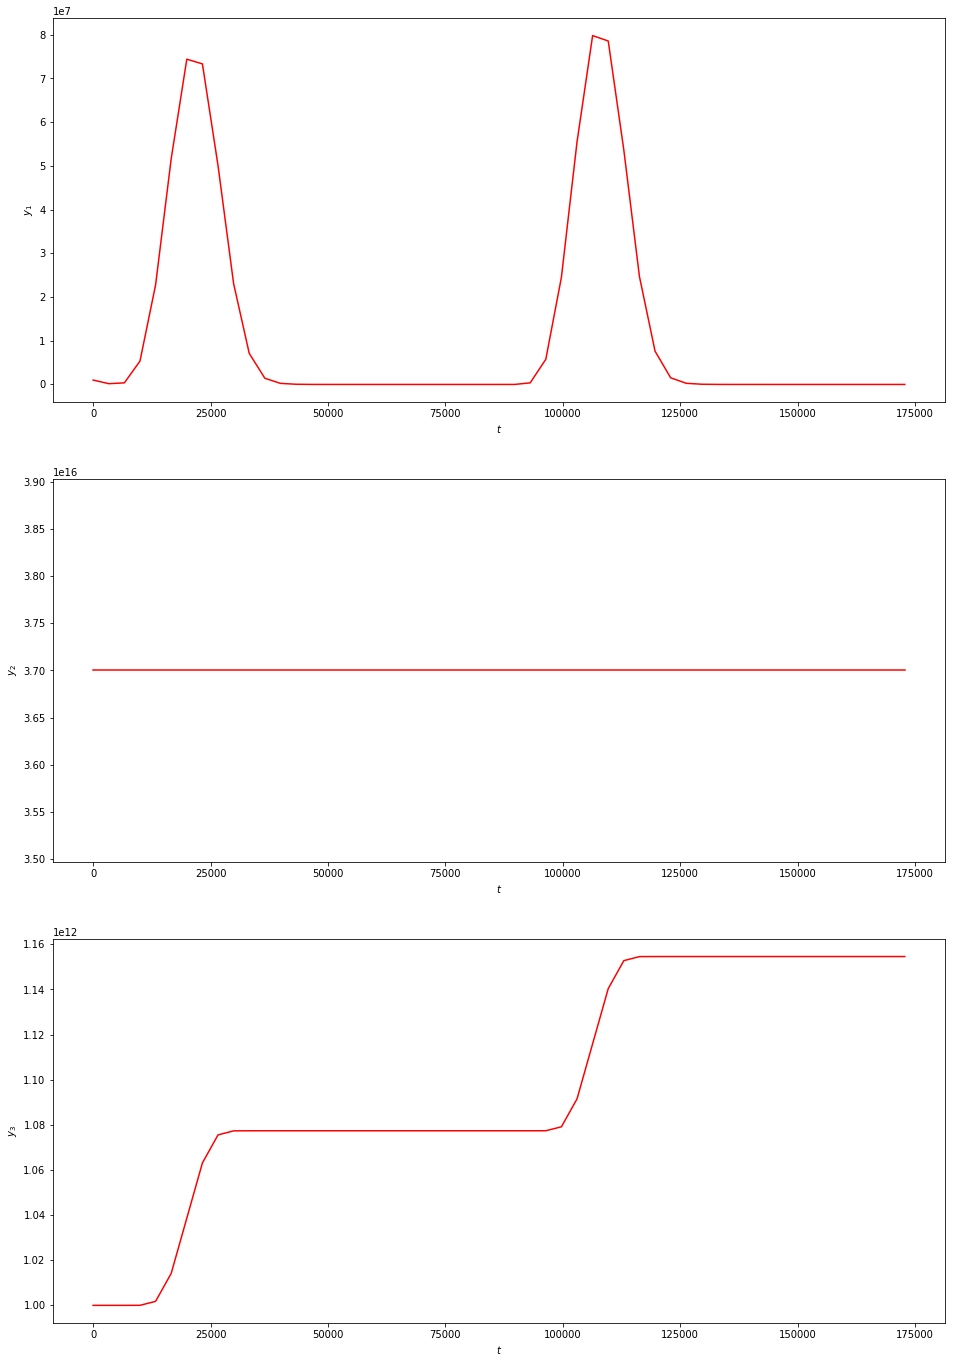

In [489]:
paragon = np.array(rung_dec.solution)
fig, axes = plt.subplots(3,1, figsize=(16, 24))
for i, ax in enumerate(axes.flatten()):
    ax.plot(paragon[:, 0], paragon[:, i+1], 'r-')
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$y_{'+str(i+1)+'}$')
plt.show()